# **Cyclistic Data Analysis project**

### Google Data Analytics Certificate Capstone Project

#### Tools used: SQL, Tableau

##### Contents
1. Scenario
2. Business task
3. Data sources
4. Cleaning and data manipulation in SQL
5. Descriptive analysis in SQL
7. Visualizations and key findings
9. Recommendations
10. Tableau dashboard: https://public.tableau.com/shared/9SW5SYXDD?:display_count=n&:origin=viz_share_link

##### Scenario
Cyclistic is a fictional bike-share company in Chicago featuring over 5,800 geotracked bicycles locked into a network of 692 docking stations, offering 3 different bike types. The marketing director believes the company’s future success depends on maximizing annual memberships. Until now, Cyclistic’s marketing strategy relied on building general awareness and appealing to broad consumer segments. One approach that helped make these things possible was the flexibility of its pricing plans: single-ride passes, full-day passes, and annual memberships. Customers who purchase single-ride or full-day passes are referred to as casual riders. Customers who purchase annual memberships are Cyclistic members.  Cyclistic’s finance analysts have concluded that annual members are much more profitable than casual riders and so there might be a solid opportunity to convert casual riders into members.

##### Business task
Annual members are much more profitable than casual ones, but the company’s flexible plan offer does not focus enough on attracting annual riders.
Business task: Analyze a full year of bike usage to share insights on casual and annual riders in order to help guide effective marketing strategies to increase annual memberships among existing and potential users. 

##### Data sources
The data has been made available by Motivate International Inc. under this license (https://divvybikes.com/data-license-agreement), to download from https://divvy-tripdata.s3.amazonaws.com/index.html. I will use historical trip data from 2021 stored across 12 CSV files for each month. BigQuery is used to upload the files individually due to their size ranging from 9MB to 150MB. At a high level, all fields will serve for the analysis except for ride_id and station_id. Ride_id was used to discard possible duplicates before dropping it. 

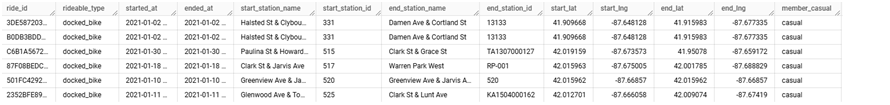

##### Cleaning and data manipulation

```python
#Data upload
#Using Python to split 5 of 12 files exceeding 100 MB in Python, in order to work in BigQuery with the 100MB limit per upload. 

import pandas as pd
import os

def split_csv(file_path, num_splits, output_dir):

    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    total_rows = len(data)

    #Determine Rows per Split with a rounded-up division
    rows_per_split = (total_rows + num_splits - 1) // num_splits

    #Iterate over each split computing start_idx and end_idx to determine range of rows per split
    for i in range(num_splits):
        start_idx = i * rows_per_split
        end_idx = min(start_idx + rows_per_split, total_rows)
        
        # Slice the DataFrame
        split_data = data.iloc[start_idx:end_idx]
        
        # Save to a new CSV file
        output_file = os.path.join(output_dir, f"split_{i + 1}.csv")
        split_data.to_csv(output_file, index=False)

file_path = # Path to CSV file
output_dir = # Directory to save split files

split_csv(file_path, 2, output_dir)
print("The file was split!")


```sql
-- SQL BigQuery
-- Combining the 17 resulting tables into a single 5,595,063 rows table with the entire year’s data

SELECT *
FROM Capstone.Cyclistic.2021_01
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_02
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_03
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_04
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_05
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_06A
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_06B
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_07A
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_07B
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_08A
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_08B
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_09A
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_09B
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_10A
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_10B
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_11
UNION ALL
SELECT *
FROM Capstone.Cyclistic.2021_12

-- Verifying duplicates: No duplicates found.

SELECT
    COUNT(ride_id) - COUNT(DISTINCT ride_id)
FROM Capstone.Cyclistic.2021

-- Removing unwanted columns, since a single table will be used, no primary keys are needed

CREATE TABLE `Capstone.Cyclistic.2021Clean1` AS
SELECT rideable_type, started_at, ended_at, start_station_name, end_station_name, start_lat, start_lng, end_lat, end_lng, member_casual  -- Excluded ride_id and station_id
FROM `Capstone.Cyclistic.2021_all`

-- Examining NULL values

SELECT
    COUNT(*) - COUNT(rideable_type) AS null_rideable_type,
    COUNT(*) - COUNT(started_at) AS null_started_at,
    COUNT(*) - COUNT(ended_at) AS null_ended_at,
    COUNT(*) - COUNT(start_station_name) AS null_start_station_name,
    COUNT(*) - COUNT(start_station_id) AS null_start_station_id,
    COUNT(*) - COUNT(end_station_name) AS null_end_station_name,
    COUNT(*) - COUNT(end_station_id) AS null_end_station_id,
    COUNT(*) - COUNT(start_lat) AS null_start_lat,
    COUNT(*) - COUNT(start_lng) AS null_start_lng,
    COUNT(*) - COUNT(end_lat) AS null_end_lat,
    COUNT(*) - COUNT(end_lng) AS null_end_lng,
    COUNT(*) - COUNT(member_casual) AS null_member_casual
FROM Capstone.Cyclistic.2021_all

 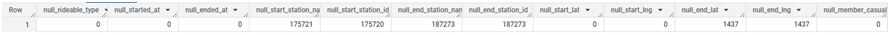

-- Deleting missing stations since geospatial data is inconsistent to fill NULL values
-- 18% of rows excluded. Removed values appeared across the entire year period, so the impact is evenly distributed

CREATE OR REPLACE TABLE Capstone.Cyclistic.2021_all AS
SELECT *
FROM Capstone.Cyclistic.2021_all
WHERE start_station_name IS NOT NULL AND end_station_name IS NOT NULL 

--Validating null values are successfully removed:

 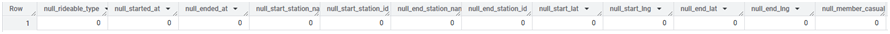 

-- Adding columns for trip duration, day of week, month, trip distance and start + end stations.

CREATE OR REPLACE TABLE Capstone.Cyclistic.Clean2 AS
SELECT *,
  TIMESTAMP_DIFF(ended_at, started_at, SECOND) AS duration_sec,
  FORMAT_TIMESTAMP('%A', started_at) AS day_of_week,
  FORMAT_TIMESTAMP('%B', started_at) AS month,
  CONCAT(TRIM(start_station_name), ' - ', TRIM(end_station_name)) AS start_end_stations,
  ST_DISTANCE( 
        ST_GEOGPOINT(start_lng, start_lat), 
        ST_GEOGPOINT(end_lng, end_lat) 
    ) AS distance_meters 
FROM Capstone.Cyclistic.Clean2

-- Removing trip duration outliers

SELECT *
FROM Capstone.Cyclistic.Clean3
WHERE duration_sec > 20 AND duration_sec < 28800 -- Excluded outliers assuming some casual users might rent a whole day 
   

##### Descriptive analysis

```sql
-- Extracted avg lat lng location for unique station names

SELECT 
    DISTINCT start_station_name AS station, 
    AVG(start_lat) AS lat
    AVG(start_lng) AS lng
FROM Capstone.Cyclistic.Clean5
GROUP BY station

5.	DESCRIPTIVE ANALYIS IN SQL

-- Daily count of usage per user type

SELECT 
  CAST(FORMAT_TIMESTAMP('%Y-%m-%d', TIMESTAMP(started_at)) AS DATE) AS day,
  COUNT(CASE WHEN member_casual = 'casual' THEN 1 END) AS count_casual,
  COUNT(CASE WHEN member_casual = 'member' THEN 1 END) AS count_member
FROM Capstone.Cyclistic.Clean5
GROUP BY day

-- Average duration across days of the week

SELECT 
    member_casual,
    AVG(CASE WHEN day_of_week = "Monday" THEN avg_duration END) AS monday_avg_duration,
    AVG(CASE WHEN day_of_week = "Tuesday" THEN avg_duration END) AS tuesday_avg_duration,
    AVG(CASE WHEN day_of_week = "Wednesday" THEN avg_duration END) AS wednesday_avg_duration,
    AVG(CASE WHEN day_of_week = "Thursday" THEN avg_duration END) AS thursday_avg_duration,
    AVG(CASE WHEN day_of_week = "Friday" THEN avg_duration END) AS friday_avg_duration,
    AVG(CASE WHEN day_of_week = "Saturday" THEN avg_duration END) AS saturday_avg_duration,
    AVG(CASE WHEN day_of_week = "Sunday" THEN avg_duration END) AS sunday_avg_duration
FROM Capstone.Cyclistic.Analysis1
GROUP BY member_casual

-- Average duration and distance weekday vs weekend

SELECT 
  member_casual,
  day_of_week,
  AVG(duration_sec)/60 AS avg_duration_min,
  AVG(distance_meters)/1000 AS avg_distance_km, 
FROM
  Capstone.Cyclistic.Clean5
GROUP BY 
  member_casual, day_of_week
ORDER BY avg_duration_min DESC

-- Frequency per weekday and month

SELECT 
    member_casual,
    day_of_week,
    month,
    rideable_type,
    COUNT(*) AS trip_count
FROM Capstone.Cyclistic.Clean5
GROUP BY member_casual, rideable_type, day_of_week, month

-- Frequency of overall station use 

SELECT 
    DISTINCT station_name,
    member_casual,
    COUNT(*) AS total_appearances
FROM (
    SELECT start_station_name AS station_name, member_casual FROM Capstone.Cyclistic.Clean5
    UNION ALL
    SELECT end_station_name AS station_name, member_casual FROM Capstone.Cyclistic.Clean5
)
GROUP BY station_name, member_casual
ORDER BY total_appearances DESC

-- Frequency of route appearance (start-end station)

SELECT
DISTINCT start_end_stations,
member_casual,
COUNT(start_end_stations) AS count_route_appearance
FROM Capstone.Cyclistic.Clean5
WHERE member_casual = "member"
GROUP BY start_end_stations, member_casual
ORDER BY 3 DESC

SELECT
DISTINCT start_end_stations,
member_casual,
COUNT(start_end_stations) AS count_route_appearance
FROM Capstone.Cyclistic.Clean5
WHERE member_casual = "casual"
GROUP BY start_end_stations, member_casual
ORDER BY 3 DESC

-- Rideable type usage per month

SELECT
  month,
  member_casual,
  rideable_type,
  COUNT(*) AS rideable_type_count,
  (COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY month)) * 100 AS bike_type_percentage
FROM Capstone.Cyclistic.Clean5
GROUP BY month, member_casual, rideable_type
ORDER BY month


##### VIsualizations and key findings

The peak season correlates to the warmer season from June to August, while February sees the lowest usage. Of the 4,555,596 total trips, casual users account for 44.7%, taking 30.7% more trips than members on weekends but 23.9% fewer on weekdays.  50% of all casual rides occur between June and August.

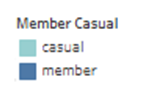
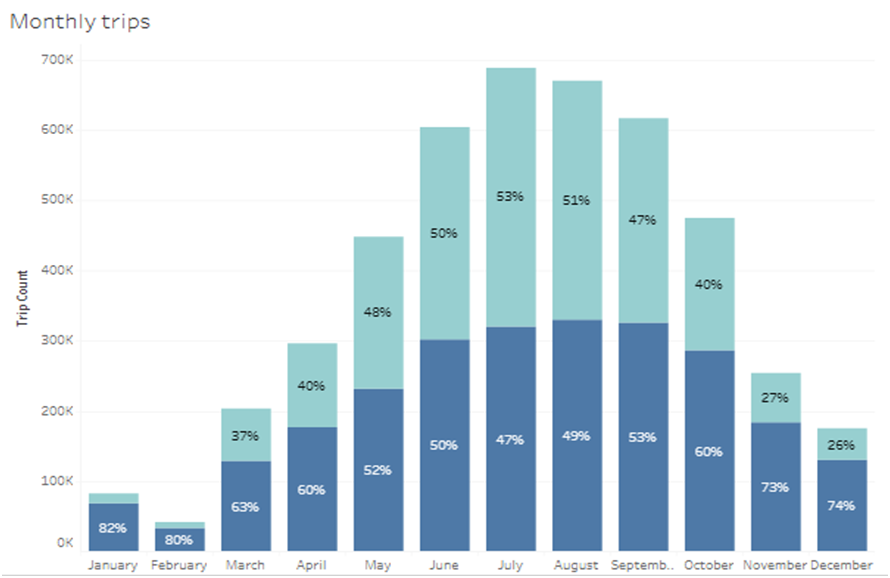

43% of casual rides happen on a weekend, with Saturday being the strongest day.

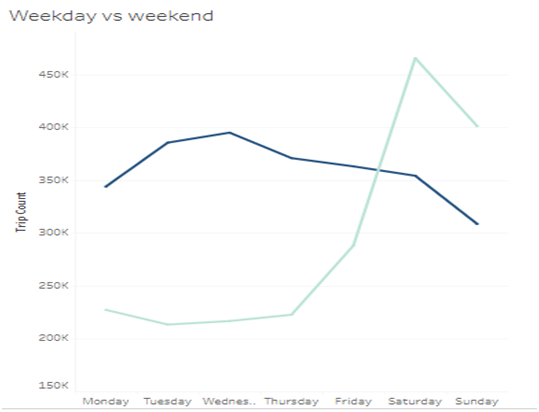

Average trip duration varies significantly, with casual users' rides being 50% longer than members' on average. Monday and Sunday see the longest ride durations.

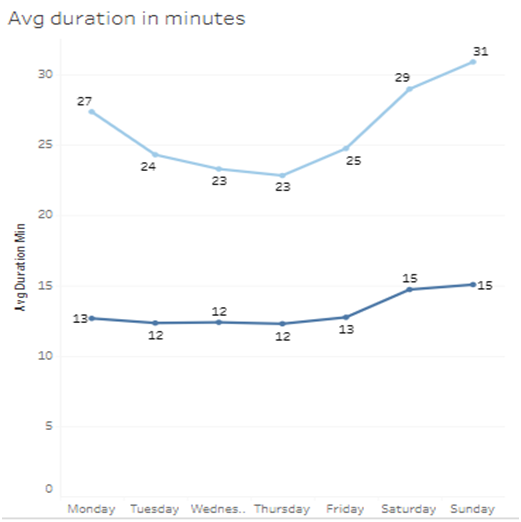

Regarding rideable types, docked bikes are almost entirely used by casual members.

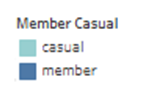
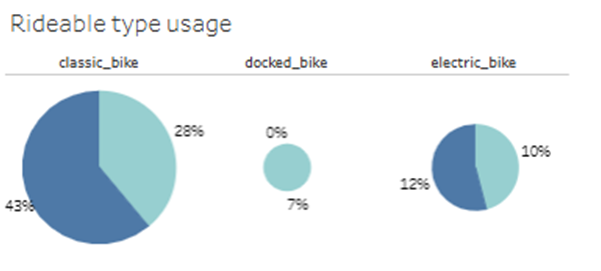

Casual rides tend to concentrate in 3-4 spots around main city and touristic attractions, with Navy Pier area are a nucleus, while member rides are more dispersed in and outside Chicago downtown.

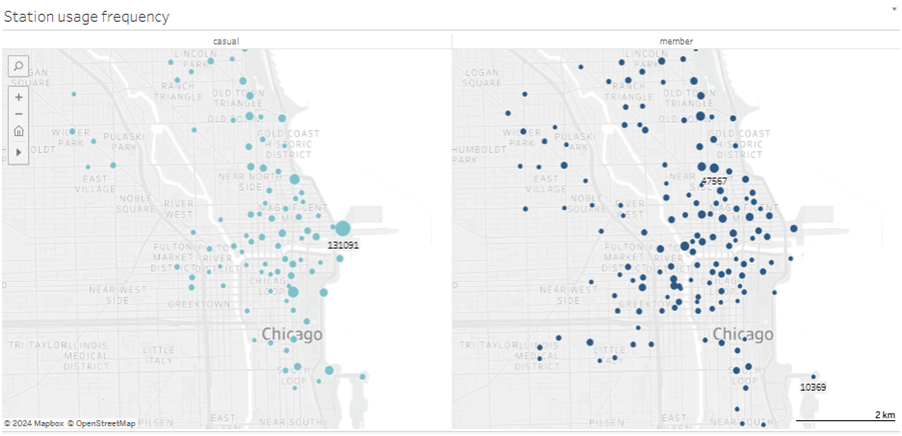



##### Recommendations

-Target Peak Months (June-August): Focus annual membership campaign actions and conversion efforts during the peak season.

-Visitor and Casual Riders: Tailor options for residents to prioritize regular and local user’s satisfaction attracting conversion.

-Zone based plans: Consider geographic or zone-based plans to differentiate one-time and full-day usage plans, while offering full coverage to annual members.

-Digital engagement: Invest in digital tracking apps to extend and optimize regular user’s experience while boosting engagement.

Further insights could be found by accessing data on identifiable users, such as residency and age to categorize profiles and usage patterns identifying different main motivations. Additionally, a survey could validate the analysis findings, while interviewing a sample of member and casual riders could provide deeper insights to effective strategies for converting casual and potential users.


##### Tableau Dashboard for peak month July 2021

https://public.tableau.com/shared/96C27X49Y?:display_count=n&:origin=viz_share_link

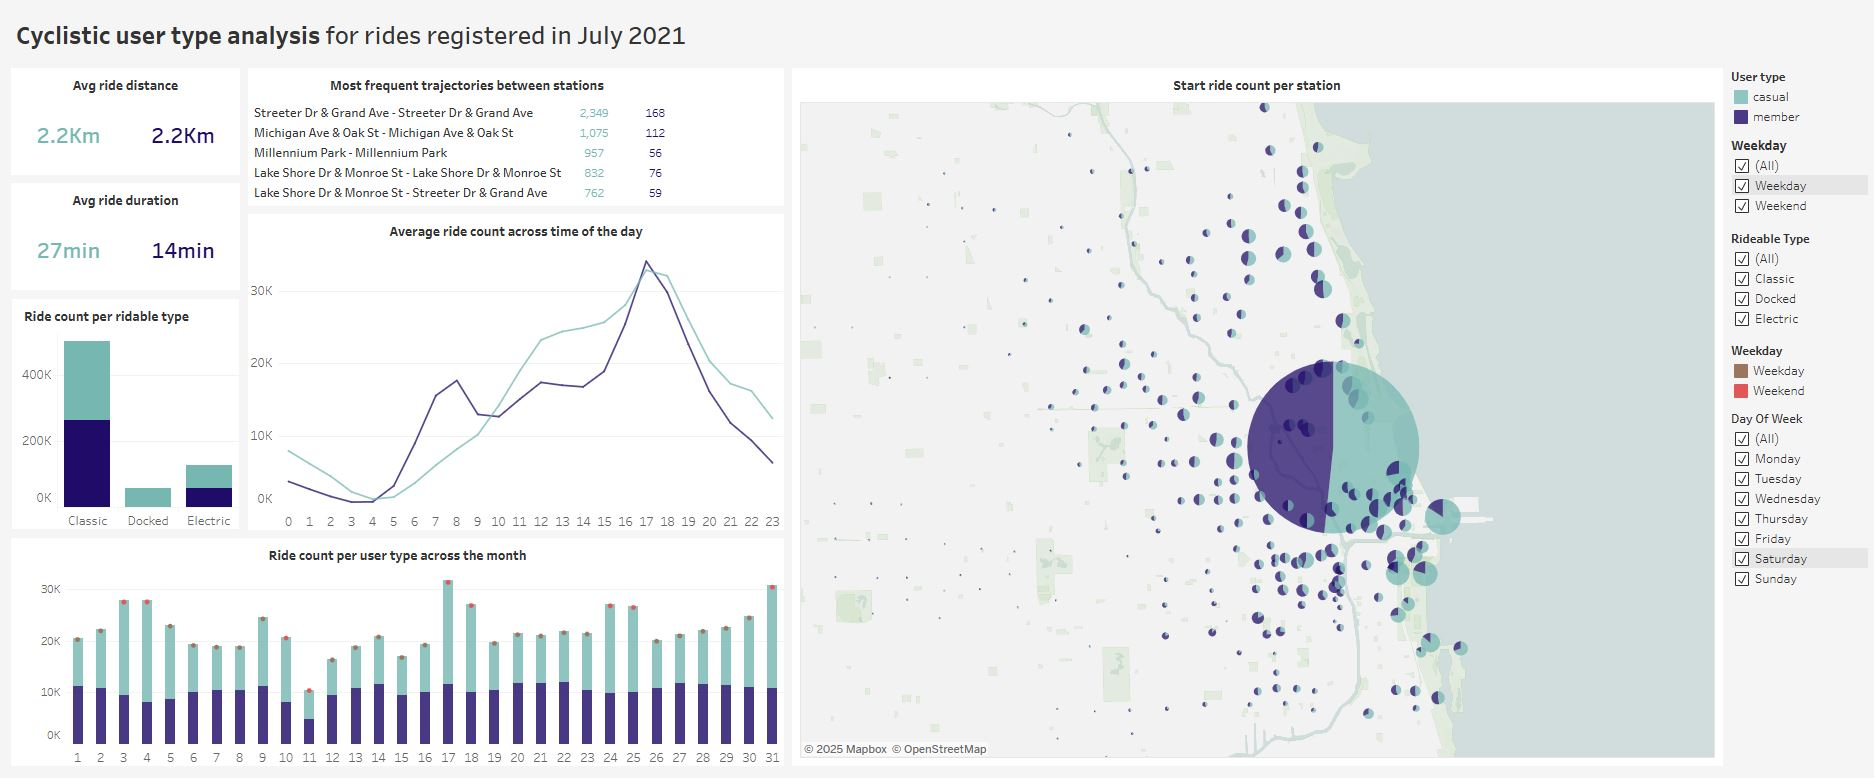
